In [ ]:
#Import Libraries

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#Downloading QQQ data and TQQQ data

ticker = 'SPY'
start = '1999-03-10'  # Start date
end = '2024-05-20'  # End date

QQQ_data = yf.download(ticker, start=start, end=end, interval='1d')

print(QQQ_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
1999-03-10  128.46875  129.25000  127.78125  129.18750  81.984680  3950000
1999-03-11  129.68750  131.18750  128.87500  130.62500  82.896950  6583700
1999-03-12  131.00000  131.03125  129.21875  129.37500  82.103638  5286500
1999-03-15  129.93750  131.25000  129.50000  131.21875  83.273735  5394400
1999-03-16  131.12500  131.65625  130.46875  130.71875  82.956429  4547500


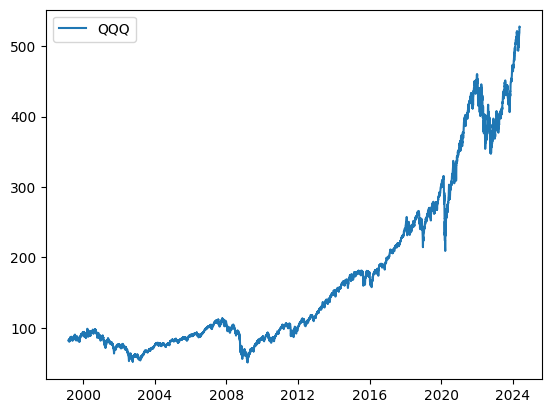

In [ ]:
plt.plot(QQQ_data['Adj Close'], label='QQQ')
plt.legend()
plt.show()

In [ ]:
#Calculating all necessary features for backtesting

# Calculate necessary variables with shifted data
QQQ_data['yesterday_Close'] = QQQ_data['Adj Close'].shift(1)
QQQ_data['two_days_ago_Close'] = QQQ_data['Adj Close'].shift(2)
QQQ_data['three_days_ago_Close'] = QQQ_data['Adj Close'].shift(3)
QQQ_data['yesterday_High'] = QQQ_data['High'].shift(1)

# Drop rows with NaN values resulting from shifting
QQQ_data.dropna(inplace=True)

# Add the day of the week as a new column
QQQ_data['day_of_week'] = QQQ_data.index.day_name()


In [18]:
#Writing code to determine if entry is viable
def entry_condition(row):
  if(row['day_of_week'] in ['Tuesday']):
    if((row['yesterday_Close'] - row['two_days_ago_Close']) / row['two_days_ago_Close'] < -0.02 and (row['two_days_ago_Close'] - row['three_days_ago_Close']) / row['three_days_ago_Close'] < -0.02):
      return True
  return False

#Writing code to determine if exit is viable
def exit_condition(row):
  if(row['Adj Close'] > row['yesterday_High']):
    return True
  return False

##Simulating the trades

In [21]:
# Initialize variables for tracking trades and performance
initial_capital = 100000.0
account_balance = initial_capital
entry_prices = []
ratio = 0.2
max_days_held = 2
trades = []
equity_curve = [initial_capital] # Start with initial capital
equity_dates = [QQQ_data.index[0]]


for index, row in QQQ_data.iterrows():
    if entry_condition(row):
        entry_price = row['Open']
        shares = account_balance * ratio / entry_price
        entry_prices.append([entry_price, shares, index])
        account_balance -= shares * entry_price
        print(f"Entry at {entry_price} on {index}, {row['Adj Close']}")

    if len(entry_prices) > 0:
        days_held = len(QQQ_data.loc[entry_prices[0][2]:index].index)  # Count trading days since entry
        if days_held >= max_days_held or exit_condition(row):
          exit_price = row['Adj Close']
          for i in entry_prices:
            trade_profits = (exit_price - i[0]) * i[1]
            account_balance += trade_profits
            trades.append([i[0], exit_price, i[1], trade_profits])

          entry_prices = []
          equity_curve.append(account_balance)
          equity_dates.append(index)

Entry at 119.4000015258789 on 2001-03-13 00:00:00, 77.79588317871094
Entry at 82.55000305175781 on 2002-07-23 00:00:00, 52.82020568847656
Entry at 85.2300033569336 on 2002-08-06 00:00:00, 57.207027435302734
Entry at 87.33999633789062 on 2008-10-28 00:00:00, 69.44540405273438
Entry at 86.7300033569336 on 2009-01-13 00:00:00, 65.043701171875
Entry at 71.61000061035156 on 2009-03-03 00:00:00, 52.32018280029297
Entry at 108.3499984741211 on 2011-10-04 00:00:00, 88.78207397460938
Entry at 195.42999267578125 on 2015-08-25 00:00:00, 159.8299560546875
Entry at 259.94000244140625 on 2018-02-06 00:00:00, 241.8636474609375
Entry at 234.4199981689453 on 2020-03-24 00:00:00, 228.21694946289062
Entry at 376.8500061035156 on 2022-06-14 00:00:00, 361.22796630859375


Final account balance: 5056.896515127745
Equity curve:  [100000.0, 72775.5500528211, 54122.42569565024, 40077.07527208532, 30647.136657580122, 22639.966815062922, 16799.71414573327, 13010.399486259706, 10052.500395375084, 7875.845599504745, 6375.670076147722, 5056.896515127745]
Trades:  [[119.4000015258789, 76.27003479003906, 167.50418546406112, -7224.449947178904], [82.55000305175781, 59.307918548583984, 176.31870953945756, -4098.014346606634], [85.2300033569336, 59.869503021240234, 127.00322319357811, -3220.8652844348762], [87.33999633789062, 71.9266357421875, 91.77256000112453, -1414.5235600881335], [86.7300033569336, 60.16037368774414, 70.67251348176052, -1877.742511001176], [71.61000061035156, 50.85668182373047, 63.23129904230222, -1312.259306317067], [108.3499984741211, 94.50379943847656, 31.010086538664428, -429.3718303269089], [195.42999267578125, 168.70608520507812, 13.314639486114075, -355.81919363268275], [259.94000244140625, 238.45765686035156, 7.734477418604352, -166.15471

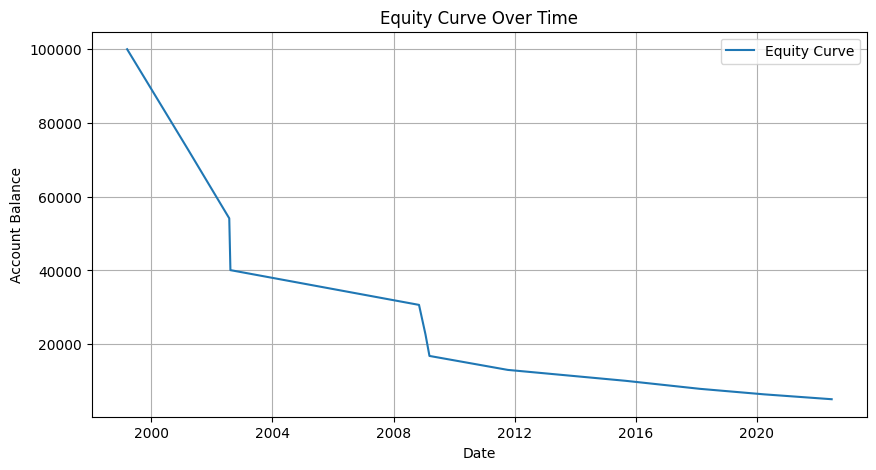

In [20]:
# If you want to print the results
print(f"Final account balance: {account_balance}")
print("Equity curve: ", equity_curve)
print("Trades: ", trades)

# Plot the equity curve
plt.figure(figsize=(10, 5))
plt.plot(equity_dates, equity_curve, label='Equity Curve')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.title('Equity Curve Over Time')
plt.legend()
plt.grid(True)
plt.show()
